In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
import os

In [9]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
save_path = os.path.join(BASE_DIR, "web", "predictor", "titanic_model.pkl")

In [10]:
train_data = pd.read_csv('../data/processed/train_features.csv')
X = train_data[['Sex','Pclass','Age','Fare','Title','FamilySize']].copy()
y = train_data['Survived']

In [11]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinDeck,FamilySize,AgeBin
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Unknown,2,Adult
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2,C,2,Adult
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Unknown,1,Adult
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2,C,2,Adult
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,Unknown,1,Adult


In [12]:
# test_train split is tested on 0.1,0.2,0.3, and 0.1 gives the highest test accuracy 
# This part is only to compare traing with single feature and all features combined,
# the final model to export to Django is the model trained with all features combined
#
accuracy = []
number_of_features = X.shape[1]
for i in range(number_of_features):
    data = X.iloc[:,[i]]
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.1, random_state=42)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] 
    accuracy.append(accuracy_score(y_test, y_pred)) 
    #print("Accuracy:", accuracy_score(y_test, y_pred))
    #print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] 
accuracy.append(accuracy_score(y_test, y_pred)) 

In [14]:
with open(save_path, "wb") as f:
    pickle.dump(model, f)

print("Model saved to:", save_path)

Model saved to: /Users/jr_huhu/Desktop/PythonLexicon/Titanic-Capstone-Project/web/predictor/titanic_model.pkl


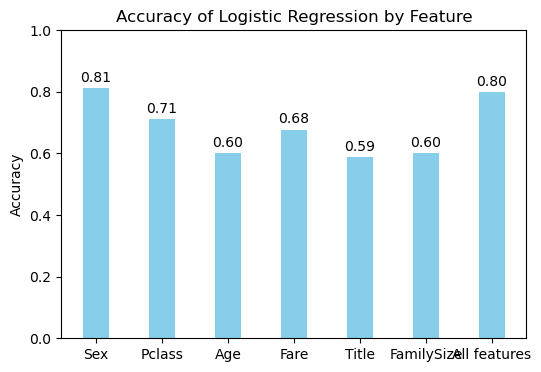

In [15]:
features = list(X.columns) 
features.append('All features')
# Plot
plt.figure(figsize=(6,4))
for i, acc in enumerate(accuracy):
    plt.bar(features[i], acc, color='skyblue',width=0.4)
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center')  

plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy of Logistic Regression by Feature')
plt.show()